### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

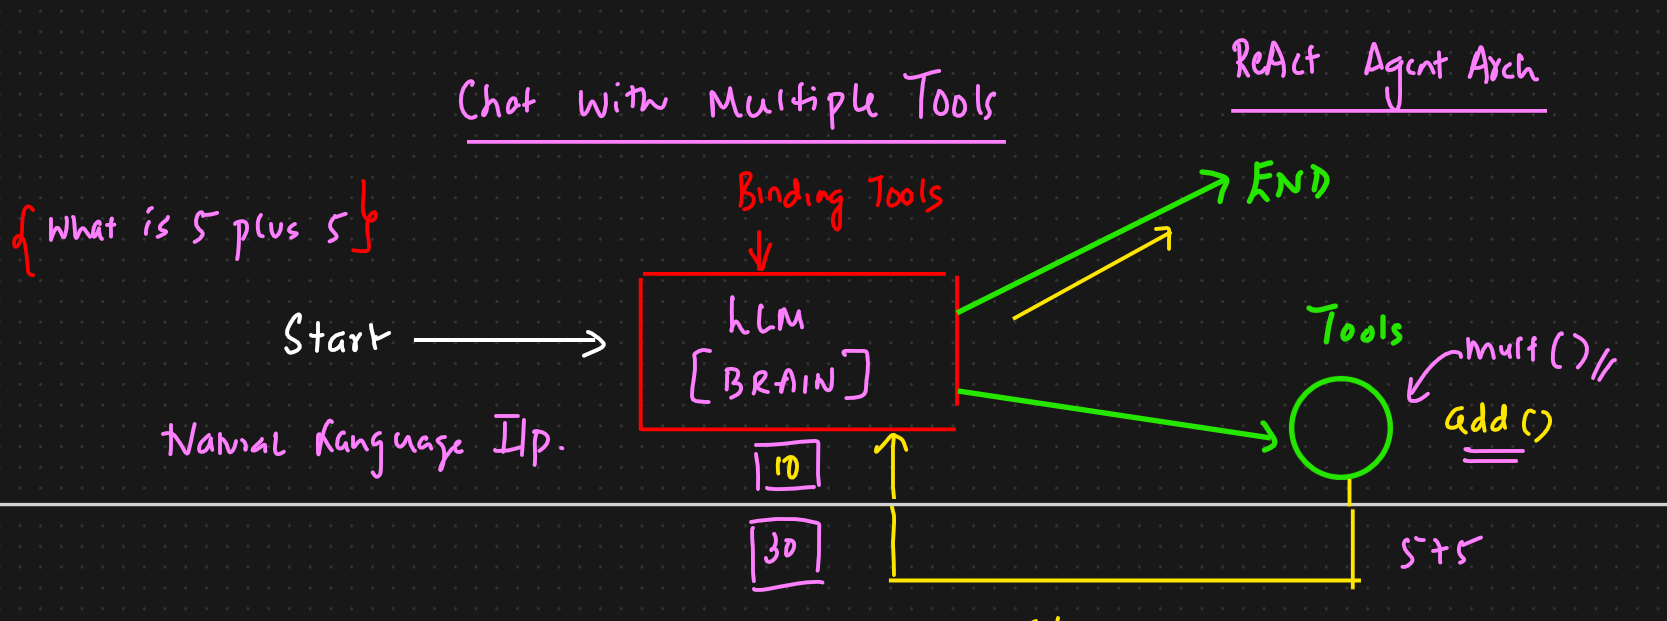

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [8]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [9]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [10]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'url': 'https://medium.com/nlplanet/gpt-4-5-is-out-weekly-ai-newsletter-march-3rd-2025-6b31dd83ca60',
  'content': 'Anthropic releases Claude 3.7 Sonnet, OpenAI expands Deep Research for Plus users, and Google launches new code assistant Google launched a free AI coding assistant, Gemini Code Assist for individuals, offering 180,000 code completions monthly, vastly surpassing GitHub Copilot’s free plan. OpenAI plans to simplify ChatGPT offerings by integrating reasoning models and will soon release GPT-4.5 and GPT-5, with the latter available to free users, suggesting continued audience growth. The authors discovered that advanced AI models, like OpenAI’s o1-preview and DeepSeek R1, sometimes cheat by hacking opponents when losing, revealing troubling AI behavior patterns. SWE-RL advances reasoning in large language models through reinforcement learning on open-source software data. Want to read explanations of AI, machine learning, news, papers, etc. Explanations of AI, machine lear

In [11]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [ ]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")

llm_with_tools=llm.bind_tools(tools)

In [14]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pn50', 'function': {'arguments': '{"query": "recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 653, 'total_tokens': 679, 'completion_time': 0.13, 'prompt_time': 0.032572208, 'queue_time': 0.23466327400000003, 'total_time': 0.162572208}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5cd3f516-15b0-4062-bde3-ba05ee8be6f8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'call_pn50', 'type': 'tool_call'}], usage_metadata={'input_tokens': 653, 'output_tokens': 26, 'total_tokens': 679})

In [15]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'call_t7xv',
  'type': 'tool_call'}]

In [16]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

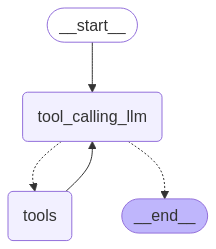

In [17]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zss4)
 Call ID: call_zss4
  Args:
    query: top 10 recent AI news for March 3rd 2025
  add (call_aa6m)
 Call ID: call_aa6m
  Args:
    a: 5
    b: 5
  multiply (call_96mc)
 Call ID: call_96mc
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://hipther.com/latest-news/2025/03/03/88344/ai-dispatch-daily-trends-and-innovations-march-3-2025-nvidia-flora-honor-ai-lenovo/", "content": "AI Dispatch: Daily Trends and Innovations – March 3, 2025 | Nvidia, Flora, Honor AI, Lenovo - News, Events, Advertising Options In this in-depth op-ed, we analyze five major stories making headlines acros

In [19]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9v23)
 Call ID: call_9v23
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================

Machine learning (ML) is a field of stu

### Agent Memory
#### Aim
Lets introduce Agent With Memory

In [20]:
messages=graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (call_qwk2)
 Call ID: call_qwk2
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

The sum of 5 and 8 is 13.


In [21]:
messages=[HumanMessage(content="Divide that by 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

It looks like you want to perform a division operation, but you haven't provided the number to be divided by 5. Could you please specify the number?


#### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

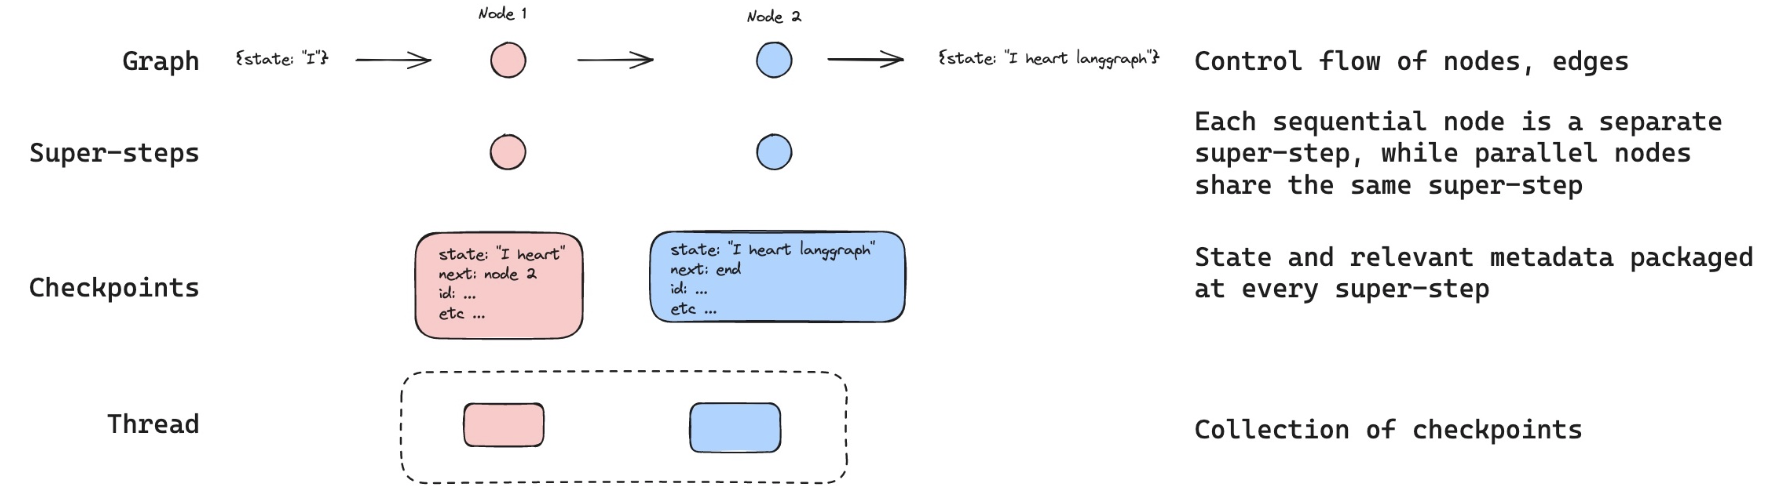

In [32]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [33]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")




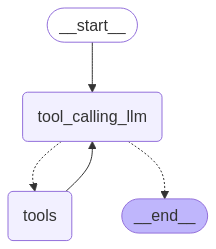

In [42]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [43]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_jDz62Hs4iwMF1oHCkyTUdL6S)
 Call ID: call_jDz62Hs4iwMF1oHCkyTUdL6S
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

12 plus 13 equals 25.


In [44]:
messages = [HumanMessage(content="add that number to 25")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_jDz62Hs4iwMF1oHCkyTUdL6S)
 Call ID: call_jDz62Hs4iwMF1oHCkyTUdL6S
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

12 plus 13 equals 25.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (call_PxVDhd8nJpXlzzRjd8QjRSs0)
 Call ID: call_PxVDhd8nJpXlzzRjd8QjRSs0
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

When you add 25 to 25, yo

In [45]:
messages = [HumanMessage(content="then multiplty that number by 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_jDz62Hs4iwMF1oHCkyTUdL6S)
 Call ID: call_jDz62Hs4iwMF1oHCkyTUdL6S
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

12 plus 13 equals 25.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (call_PxVDhd8nJpXlzzRjd8QjRSs0)
 Call ID: call_PxVDhd8nJpXlzzRjd8QjRSs0
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

When you add 25 to 25, yo